# Prediction Interface
This example will demonstrate how to use the `Prediction` class, which is designed to interface with prediction-correction algorithms like the Kalman filter. While the `Simulation` class from previous examples manages its own state and is designed to simulate full timeseries data, the `Prediction` class requires the user to manage the state, and is only designed to make step-by-step predictions.

## Import Modules
In addition to the `thevenin` package we will also import `time` and `matplotlib` here because we will compare how quickly the `Prediction` class takes steps relative to trying to use the `Simulation` class for the same purpose. We will also demonstrate that both interfaces produce consistent outputs.

In [16]:
import time

import numpy as np
import thevenin as thev
import matplotlib.pyplot as plt

## Construct Models
For the purposes of this example we will use the default parameters that are included with `thevenin`. Both the `Simulation` and `Prediction` class share the same overall construction so users can easily create a single input and use it for either interface. When no input is given, `thevenin` users an internal `yaml` file to setup the model. The included parameters are generally only useful for tutorials. They are made up and do not represent any specific real-world battery.

In [17]:
sim = thev.Simulation()
pred = thev.Prediction()


[thevenin UserWarning] Using the default parameter file 'params.yaml'.


[thevenin UserWarning] Using the default parameter file 'params.yaml'.



## Baseline 1C Discharge
The `Simulation` class is primary setup to run full timeseries simulations. In the codeblock below we will run and save the results from a 1C discharge experiment. This will be used later to show that all results are consistent. 

In a later subsection, we also demonstrate how `Simulation` can technically be used for step-by-step predictions so long as the user does not need access to manually control the state. However, when run for this purpose, `Simulation` will generally take significantly longer to run compared to running an experiment "normally". To compare the runtimes of all cases, we capture the baseline performance below using `time`.

In [18]:
expr = thev.Experiment()
expr.add_step('current_C', 1., (3600., 1.), limits=('voltage_V', 3.))

start = time.time()
baseline = sim.run(expr)
stop = time.time()

t_baseline = stop - start

## Stepping Simulation
As mentioned above, the `Simulation` class is not optimized for step-by-step time predictions. This is not to be confused with an experimental step. A step-by-step prediction here is defined as using the model to take a single time step to predict the state. An experimental step typically consists of multiple time steps, for example, saving the discharge solution in increments of 1 second across a full hour.

Since `Simulation` manages the model state internally there is typically no benefit to running as we demonstrate below, it is simply for comparison purposes. The reason `Simulation` takes longer to run in this manner is due to the solver initialization and linear constraints solver. When an experiment is run all in one go (as above), the solver is able to reuse internal Jacobians as it moves forward in time as long as they do not conflict with the set tolerances. In contrast, running step-by-step requires the solver to reinitialize and determine the Jacobian every time `run_step` is called. Consequently, the overall solve time suffers. In fact, we will even give an advantage to the stepped `Simulation` run below by taking steps of 10 seconds rather than 1 second so that the overall number of steps is only 360.

In [19]:
step = thev.Experiment()
step.add_step('current_C', 1., (10., 1))

start = time.time()
solns = []
for i in range(360):
    solns.append(sim.run_step(step, 0))  # repeat the same step over and over
stop = time.time()
    
stepped_sim = thev.CycleSolution(*solns, t_shift=0.)  # stitch the solutions
t_stepped_sim = stop - start

## Stepping Prediction
The way that the `Prediction` model is setup allows the user to completely manage the state at each step. This makes it great for prediction-correction algorithms where the user "corrects" the state after each prediction prior to making the next prediction. A common algorithm that is used for this purpose involves the Kalman filter. Since the underlying model is non-linear, an unscented Kalman filter is specifically required to interface with `Prediction`.

To speed up the step-by-step runtime for the `Prediction` class, the model is recast as a pure system of ODEs rather than a DAE by removing the ability to demand voltage and power. By forcing the model to only work with current-based demands, an algebraic constraint that exists in the `Simulation` wrapper's formulation can be removed, leading to a more optimized initialization process and drastically reducing runtimes when exercised in a step-by-step prediction mode. To demonstrate this we will take 10 times more time steps below, for a total of 3600, compared to the 360 steps taken above with `Simulation`.

In [20]:
state = thev.TransientState(soc=1., T_cell=300., hyst=0., eta_j= [0.])

times = np.linspace(0, 3600, 3601)
current = pred.capacity  # constant demand current at each step

voltage = np.empty(times.size)  # empty array to save voltage outputs
voltage[0] = pred.ocv(state.soc)  # the voltage at t=0 is the resting OCV

start = time.time()
for i in range(3600):
    state = pred.take_step(state, current, 1.)
    voltage[i+1] = state.voltage
stop = time.time()

t_stepped_pred = stop - start

## Compare Outputs
Before we show the differences in runtime, let's make sure that the outputs from all methods match. The figure below overlays the time vs. voltage results from each method above. You can see that all results are in good agreement with one another. Notice however that the baseline case stopped a little earlier than the other two cases because a limit was set to not surpass 3 V. In a step-by-step prediction mode it isn't expected that you would need to use limits because you can simply check the state yourself after each prediction, and use the results to determine whether or not you want to take another step.

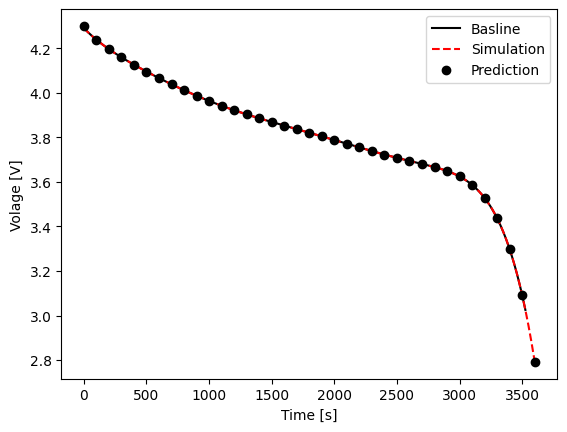

In [23]:
plt.figure()
plt.plot(
    baseline.t, baseline.vars['voltage_V'], '-k',
    stepped_sim.t, stepped_sim.vars['voltage_V'], '--r',
    times[::100], voltage[::100], 'ok',
)
plt.xlabel('Time [s]');
plt.ylabel('Volage [V]');
plt.legend(['Basline', 'Simulation', 'Prediction']);

## Compare Runtimes
You can see the runtimes for each case below. Note that the baseline case is the fastest. Regardless of using `Simulation` or `Prediction`, there is overhead involved in stepping into and out of the solver in order to take individual time steps for the other two cases. However, this overhead is much higher for the `Simulation` wrapper due to the more costly DAE initialization routine. Remember, the step-by-step simulation case was allowed to take 10-second steps and only ran a total of 360 times. Despite this, the overall runtime is very close to the `Prediction` case which used 1-second steps and executed a total of 3600 predictions. In general, our basic testing has demonstrated that the `Prediction` class can be around 8-12 times faster than the `Simulation` class when used in this step-by-step manner. In addition, the `Prediction` class comes with the added benefit of allowing the user to manage the state, which is necessary for algorithms like the Kalman filter.

In [22]:
print(f"Baseline: {t_baseline:.5f} s")
print(f"Simulation (10s steps, 360x): {t_stepped_sim:.5f} s")
print(f"Prediction (1s steps, 3600x): {t_stepped_pred:.5f} s")

Baseline: 0.01985 s
Simulation (10s steps, 360x): 0.40444 s
Prediction (1s steps, 3600x): 0.52859 s
